# EDA

## Visualizing

In [ ]:
from datasets import load_dataset
import pandas as pd

ds = load_dataset("go_emotions")

print(ds)
print(ds["train"].features)
print(ds["train"][0:10])

# unique input counts
label_counts = pd.Series(ds["train"]["labels"]).value_counts()
print("Label counts:")
print(label_counts)

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 43410
    })
    validation: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 5426
    })
    test: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 5427
    })
})
{'text': Value('string'), 'labels': List(ClassLabel(names=['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral'])), 'id': Value('string')}
{'text': ["My favourite food is anything I didn't have to cook myself.", 'Now if he does off himself, everyone will think hes having a laugh screwing with people instead of actually dead', 'WHY THE FUCK IS BAYLESS ISOING', 'To make her feel threatened', 'Dirty Southern Wanke

## Sentiment Mapping

In [ ]:
from os import device_encoding
import numpy as np

sentiment_mapping = {
    'admiration': 'positive',
    'amusement': 'positive',
    'anger': 'negative',
    'annoyance': 'negative',
    'approval': 'positive',
    'caring': 'positive',
    'confusion': 'neutral',
    'curiosity': 'neutral',
    'desire': 'positive',
    'disappointment': 'negative',
    'disapproval': 'negative',
    'disgust': 'negative',
    'embarrassment': 'negative',
    'excitement': 'positive',
    'fear': 'negative',
    'gratitude': 'positive',
    'grief': 'negative',
    'joy': 'positive',
    'love': 'positive',
    'nervousness': 'negative',
    'optimism': 'positive',
    'pride': 'positive',
    'realization': 'neutral',
    'relief': 'positive',
    'remorse': 'negative',
    'sadness': 'negative',
    'surprise': 'neutral',
    'neutral': 'neutral',
    }

sign = {
    'positive': 1,
    'neutral': 0,
    'negative': -1
    }

label_names = ds["train"].features["labels"].feature.names

def avg_polarity_from_ids(label_ids):
    if not label_ids:
        return 0.0
    vals = [sign[sentiment_mapping[label_names[i]]] for i in label_ids]
    return float(sum(vals) / len(vals))

def add_targets(ex):
    ap = avg_polarity_from_ids(ex["labels"])
    ex["avg_polarity"] = ap
    return ex

ds = ds.map(add_targets)

# Remove the original 'labels' column (list of integers)
if "labels" in ds["train"].column_names:
    ds = ds.remove_columns("labels")

# For regression: rename avg_polarity -> labels
ds = ds.rename_column("avg_polarity", "labels")

ds["train"][50:55]

{'text': ['FBI!! OPEN UP!!!',
  'Should’ve dumped coke all over her right after the movie, and make a run for it. Fk pettiness ',
  'You can always kneel.',
  'Cheers, sololander!',
  'Very interesting. Thx'],
 'labels': [[27], [27], [4], [27], [13, 15]],
 'id': ['eebp801', 'eer0jny', 'eek294p', 'eex7fm9', 'eeb757w']}

## Preprocessing


In [ ]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import string

# Contraction Mapping
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                       "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                       "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will",
                       "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am",
                       "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am",
                       "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have",
                       "it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not",
                       "mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not",
                       "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not",
                       "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will",
                       "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have",
                       "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is",
                       "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would",
                       "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have",
                       "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have",
                       "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have",
                       "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did",
                       "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is",
                       "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                       "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would",
                       "y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have",
                       "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have", 'u.s':'america', 'e.g':'for example'}

# Spelling Mapping
mispell_dict = {'colour': 'color', 'centre': 'center', 'favourite': 'favorite', 'travelling': 'traveling', 'counselling': 'counseling', 'theatre': 'theater',
                'cancelled': 'canceled', 'labour': 'labor', 'organisation': 'organization', 'wwii': 'world war 2', 'citicise': 'criticize', 'youtu ': 'youtube ',
                'Qoura': 'Quora', 'sallary': 'salary', 'Whta': 'What', 'narcisist': 'narcissist', 'howdo': 'how do', 'whatare': 'what are', 'howcan': 'how can',
                'howmuch': 'how much', 'howmany': 'how many', 'whydo': 'why do', 'doI': 'do I', 'theBest': 'the best', 'howdoes': 'how does',
                'mastrubation': 'masturbation', 'mastrubate': 'masturbate', "mastrubating": 'masturbating', 'pennis': 'penis', 'Etherium': 'Ethereum',
                'narcissit': 'narcissist', 'bigdata': 'big data', '2k17': '2017', '2k18': '2018', 'qouta': 'quota', 'exboyfriend': 'ex boyfriend',
                'airhostess': 'air hostess', "whst": 'what', 'watsapp': 'whatsapp', 'demonitisation': 'demonetization', 'demonitization': 'demonetization',
                'demonetisation': 'demonetization'}

# Punctuation Mapping - Only for Reddit dataset

punct = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£',
 '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…',
 '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─',
 '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞',
 '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', ]

punct_mapping = {"‘": "'", "₹": "e", "´": "'", "°": "", "€": "e", "™": "tm", "√": " sqrt ", "×": "x", "²": "2", "—": "-", "–": "-", "’": "'", "_": "-",
                 "`": "'", '“': '"', '”': '"', '“': '"', "£": "e", '∞': 'infinity', 'θ': 'theta', '÷': '/', 'α': 'alpha', '•': '.', 'à': 'a', '−': '-',
                 'β': 'beta', '∅': '', '³': '3', 'π': 'pi', '!':' '}

def lower_text(text):
    text = text.lower()  # Convert to lowercase
    return text

def clean_contractions(text, mapping):
    '''Clean contraction using contraction mapping'''
    specials = ["’", "‘", "´", "`"]
    for s in specials:
        text = text.replace(s, "'")
    for word in mapping.keys():
        if ""+word+"" in text:
            text = text.replace(""+word+"", ""+mapping[word]+"")
    #Remove Punctuations
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    text = re.sub(r"([?.!,¿])", r" \1 ", text)
    text = re.sub(r'[" "]+', " ", text)
    return text

def clean_special_chars(text, punct, mapping):
    '''Cleans special characters present(if any)'''
    for p in mapping:
        text = text.replace(p, mapping[p])

    for p in punct:
        text = text.replace(p, f' {p} ')

    specials = {'\u200b': ' ', '…': ' ... ', '\ufeff': '', 'करना': '', 'है': ''}
    for s in specials:
        text = text.replace(s, specials[s])

    return text

def correct_spelling(x, dic):
    '''Corrects common spelling errors'''
    for word in dic.keys():
        x = x.replace(word, dic[word])
    return x

def remove_space(text):
    '''Removes awkward spaces'''
    #Removes awkward spaces
    text = text.strip()
    text = text.split()
    return " ".join(text)

def text_preprocessing_pipeline(text):
    '''Cleaning and parsing the text.'''
    text = lower_text(text)
    text = clean_contractions(text, contraction_mapping)
    text = clean_special_chars(text, punct, punct_mapping)
    text = correct_spelling(text, mispell_dict)
    text = remove_space(text)
    return text

ds = ds.map(lambda example: {"text": text_preprocessing_pipeline(example["text"])})

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Map:   0%|          | 0/43410 [00:00<?, ? examples/s]

Map:   0%|          | 0/5426 [00:00<?, ? examples/s]

Map:   0%|          | 0/5427 [00:00<?, ? examples/s]

# Model

## Tokenization


In [ ]:
from transformers import (AutoTokenizer, AutoModelForSequenceClassification,
                          DataCollatorWithPadding, Trainer, TrainingArguments)
from peft import LoraConfig, get_peft_model, TaskType
# pip install evaluate
import evaluate

MODEL = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL)

def tok(batch):
    return tokenizer(batch["text"], truncation=True, max_length=128)

tokenized = ds.map(tok, batched=True, remove_columns=[c for c in ds["train"].column_names if c not in ["text","labels"]])
collator = DataCollatorWithPadding(tokenizer=tokenizer)

tokenized["train"][0:5]

{'text': ['my favorite food is anything i did not have to cook myself',
  'now if he does off himself everyone will think hes having a laugh screwing with people instead of actually dead',
  'why the fuck is bayless isoing',
  'to make her feel threatened',
  'dirty southern wankers'],
 'labels': [0.0, 0.0, -1.0, -1.0, -1.0],
 'input_ids': [[101,
   2026,
   5440,
   2833,
   2003,
   2505,
   1045,
   2106,
   2025,
   2031,
   2000,
   5660,
   2870,
   102],
  [101,
   2085,
   2065,
   2002,
   2515,
   2125,
   2370,
   3071,
   2097,
   2228,
   2002,
   2015,
   2383,
   1037,
   4756,
   29082,
   2007,
   2111,
   2612,
   1997,
   2941,
   2757,
   102],
  [101, 2339, 1996, 6616, 2003, 3016, 3238, 11163, 2075, 102],
  [101, 2000, 2191, 2014, 2514, 5561, 102],
  [101, 6530, 2670, 14071, 11451, 102]],
 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0,

## Model + LoRA

In [ ]:
base = AutoModelForSequenceClassification.from_pretrained(MODEL, num_labels=1, problem_type="regression")
lora_cfg = LoraConfig(task_type=TaskType.SEQ_CLS, r=8, lora_alpha=16, lora_dropout=0.1, target_modules=["query","value"])
model = get_peft_model(base, lora_cfg)
model.print_trainable_parameters()

train_ds = tokenized["train"]
val_ds   = tokenized["validation"]
test_ds  = tokenized["test"]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 295,681 || all params: 109,778,690 || trainable%: 0.2693


## Evaluation (MSE/MAE)


In [ ]:
# pip install optuna

mse = evaluate.load("mse")
mae = evaluate.load("mae")

def compute_metrics_reg(eval_pred):
    logits, labels = eval_pred
    preds = logits.squeeze(-1)
    return {
        "mse": mse.compute(predictions=preds, references=labels)["mse"],
        "mae": mae.compute(predictions=preds, references=labels)["mae"],
    }

args = TrainingArguments(
    output_dir="out_bert_lora_reg",
    learning_rate=2e-4,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    num_train_epochs=3,
    eval_strategy="epoch",
    logging_strategy="steps",
    logging_steps=100,
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="mse",
    report_to="none"
)

trainer = Trainer(
    model=model, args=args, train_dataset=train_ds, eval_dataset=val_ds,
    tokenizer=tokenizer, data_collator=collator, compute_metrics=compute_metrics_reg, model_init=model_init
)

def model_init():
    return AutoModelForSequenceClassification.from_pretrained(
        MODEL, num_labels=1, problem_type="regression", return_dict=True) # num_labels?

trainer.hyperparameter_search(
    direction="minimize",
    backend="optuna",
    n_trials=5
)

trainer.train()
trainer.evaluate(test_ds)
model.save_pretrained("bert_lora_adapter_reg")
tokenizer.save_pretrained("bert_lora_adapter_reg")

/tmp/ipython-input-3700284136.py:29: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.12/dist-packages/transformers/trainer.py:479: FutureWarning: `Trainer` requires either a `model` or `model_init` argument, but not both. `model_init` will overwrite your model when calling the `train` method. This will become a fatal error in the next release.
  warnings.warn(
[I 2025-10-30 14:54:00,583] A new study created in memory with name: no-name-e2b4be0e-f364-4b44-a493-2d4fce8b0fd2
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Mse,Mae
1,0.255700,0.235858,0.235858,0.327527
2,0.187600,0.235500,0.235500,0.312272
3,0.196200,0.236756,0.236756,0.307349


[I 2025-10-30 15:25:40,000] Trial 0 finished with value: 0.5441051574712739 and parameters: {'learning_rate': 2.083734378691061e-06, 'num_train_epochs': 3, 'seed': 13, 'per_device_train_batch_size': 4}. Best is trial 0 with value: 0.5441051574712739.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Mse,Mae
1,0.240100,0.233424,0.233424,0.310078


[I 2025-10-30 15:36:15,477] Trial 1 finished with value: 0.5435015813447688 and parameters: {'learning_rate': 5.021674051421181e-06, 'num_train_epochs': 1, 'seed': 12, 'per_device_train_batch_size': 4}. Best is trial 1 with value: 0.5435015813447688.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Mse,Mae
1,0.249200,0.239750,0.239750,0.355005


[I 2025-10-30 15:40:34,218] Trial 2 finished with value: 0.5947544307176206 and parameters: {'learning_rate': 7.81897497502867e-06, 'num_train_epochs': 1, 'seed': 1, 'per_device_train_batch_size': 64}. Best is trial 1 with value: 0.5435015813447688.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Mse,Mae
1,0.237200,0.233106,0.233106,0.332911
2,0.171100,0.239398,0.239398,0.338732
3,0.108100,0.245129,0.245129,0.313805
4,0.068700,0.260535,0.260535,0.311723


[I 2025-10-30 15:57:35,457] Trial 3 finished with value: 0.5722581546634291 and parameters: {'learning_rate': 5.796274355895665e-05, 'num_train_epochs': 4, 'seed': 2, 'per_device_train_batch_size': 64}. Best is trial 1 with value: 0.5435015813447688.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Mse,Mae
1,0.257600,0.235146,0.235146,0.323878
2,0.181800,0.232029,0.232029,0.307787


[I 2025-10-30 16:10:51,162] Trial 4 finished with value: 0.5398159949301884 and parameters: {'learning_rate': 2.4636802734770046e-05, 'num_train_epochs': 2, 'seed': 29, 'per_device_train_batch_size': 8}. Best is trial 4 with value: 0.5398159949301884.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Mse,Mae
1,0.257600,0.235146,0.235146,0.323878
2,0.181800,0.232029,0.232029,0.307787


('bert_lora_adapter_reg/tokenizer_config.json',
 'bert_lora_adapter_reg/special_tokens_map.json',
 'bert_lora_adapter_reg/vocab.txt',
 'bert_lora_adapter_reg/added_tokens.json',
 'bert_lora_adapter_reg/tokenizer.json')

In [ ]:
mse = evaluate.load("mse")
mae = evaluate.load("mae")

def compute_metrics_reg(eval_pred):
    logits, labels = eval_pred
    preds = logits.squeeze(-1)
    return {
        "mse": mse.compute(predictions=preds, references=labels)["mse"],
        "mae": mae.compute(predictions=preds, references=labels)["mae"],
    }

args = TrainingArguments(
    output_dir="out_bert_lora_reg",
    learning_rate=2.4636802734770046e-05,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=8,
    num_train_epochs=2,
    eval_strategy="epoch",
    logging_strategy="steps",
    logging_steps=100,
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="mse",
    report_to="none"
)

trainer = Trainer(
    model=model, args=args, train_dataset=train_ds, eval_dataset=val_ds,
    tokenizer=tokenizer, data_collator=collator, compute_metrics=compute_metrics_reg
)
trainer.train()
trainer.evaluate(test_ds)
model.save_pretrained("bert_lora_adapter_reg")
tokenizer.save_pretrained("bert_lora_adapter_reg")



/tmp/ipython-input-2831783546.py:27: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Mse,Mae
1,0.165300,0.241416,0.241416,0.328118
2,0.217900,0.234575,0.234575,0.325802


('bert_lora_adapter_reg/tokenizer_config.json',
 'bert_lora_adapter_reg/special_tokens_map.json',
 'bert_lora_adapter_reg/vocab.txt',
 'bert_lora_adapter_reg/added_tokens.json',
 'bert_lora_adapter_reg/tokenizer.json')

## Evaluation (Acc/F1)

In [ ]:
import numpy as np

def add_cls(example, tol=1e-8):
    ap = example["labels"] # use the avg_polarity float value directly
    if np.isclose(ap, 0.0, atol=tol):
        cls = 1
    elif ap > 0:
        cls = 2
    else:
        cls = 0
    example["avg_polarity"] = float(ap)
    example["cls_label"]   = int(cls)
    return example

ds = ds.map(add_cls)

print("train cls counts:", np.bincount(ds["train"]["cls_label"], minlength=3))
print("val   cls counts:", np.bincount(ds["validation"]["cls_label"], minlength=3))

Map:   0%|          | 0/43410 [00:00<?, ? examples/s]

Map:   0%|          | 0/5426 [00:00<?, ? examples/s]

Map:   0%|          | 0/5427 [00:00<?, ? examples/s]

train cls counts: [ 9059 17703 16648]
val   cls counts: [1125 2192 2109]


In [ ]:
acc = evaluate.load("accuracy")
f1  = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, cls_label = eval_pred
    preds = logits.argmax(axis=-1)
    return {
        "accuracy": acc.compute(predictions=preds, references=cls_label)["accuracy"],
        "f1_macro": f1.compute(predictions=preds, references=cls_label, average="macro")["f1"]
    }

args = TrainingArguments(
    output_dir="out_bert_lora_cls3",
    learning_rate=2e-4,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    num_train_epochs=3,
    eval_strategy="epoch",
    logging_strategy="steps",
    logging_steps=100,
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    report_to="none"
)

trainer = Trainer(
    model=model, args=args, train_dataset=train_ds, eval_dataset=val_ds,
    tokenizer=tokenizer, data_collator=collator, compute_metrics=compute_metrics
)
trainer.train()
trainer.evaluate(test_ds)
model.save_pretrained("bert_lora_adapter_cls3")
tokenizer.save_pretrained("bert_lora_adapter_cls3")


/tmp/ipython-input-2447115949.py:27: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.221400,0.241166,0.455400,0.208602
2,0.228700,0.231250,0.455400,0.208602
3,0.214600,0.229356,0.455400,0.208602


('bert_lora_adapter_cls3/tokenizer_config.json',
 'bert_lora_adapter_cls3/special_tokens_map.json',
 'bert_lora_adapter_cls3/vocab.txt',
 'bert_lora_adapter_cls3/added_tokens.json',
 'bert_lora_adapter_cls3/tokenizer.json')

In [ ]:
import numpy as np

pred = trainer.predict(test_ds)
y_true = pred.label_ids.astype(float)
y_pred = pred.predictions.squeeze(-1).astype(float)

print("MAE:", np.mean(np.abs(y_pred - y_true)))
print("MSE:", np.mean((y_pred - y_true)**2))

MAE: 0.3221888517324579
MSE: 0.23204991234692487


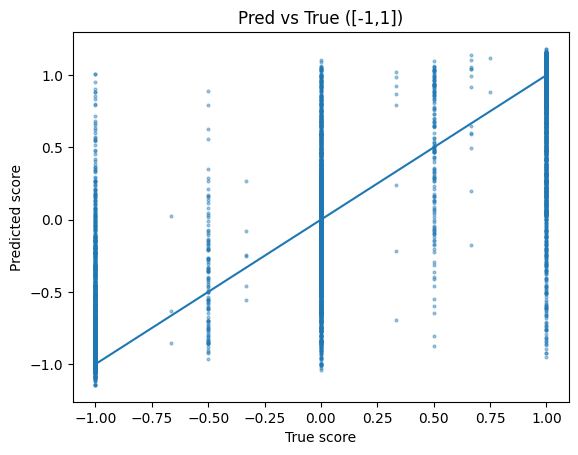

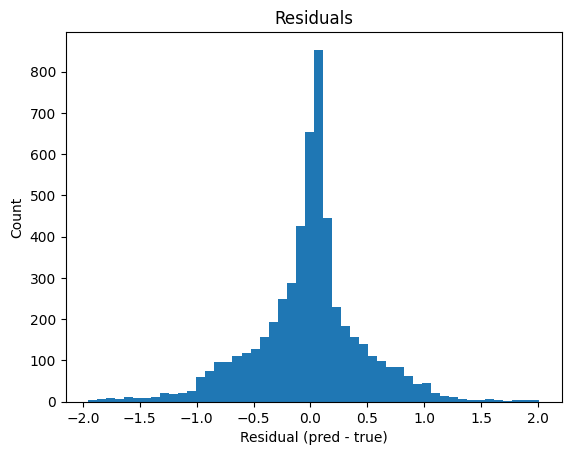

In [ ]:
import matplotlib.pyplot as plt

# predicted vs true
plt.figure(); plt.scatter(y_true, y_pred, s=4, alpha=0.4)
plt.plot([-1,1],[-1,1])
plt.xlabel("True score"); plt.ylabel("Predicted score"); plt.title("Pred vs True ([-1,1])")
plt.show()

# residuals histogram
res = y_pred - y_true
plt.figure(); plt.hist(res, bins=50)
plt.xlabel("Residual (pred - true)"); plt.ylabel("Count"); plt.title("Residuals")
plt.show()


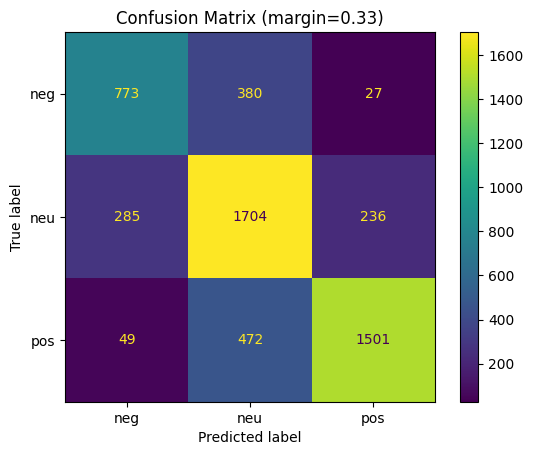

              precision    recall  f1-score   support

         neg       0.70      0.66      0.68      1180
         neu       0.67      0.77      0.71      2225
         pos       0.85      0.74      0.79      2022

    accuracy                           0.73      5427
   macro avg       0.74      0.72      0.73      5427
weighted avg       0.74      0.73      0.73      5427



In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

def to_3cls(x, margin=0.5):
    if x >=  margin: return 2   # pos
    if x <= -margin: return 0   # neg
    return 1                    # neu

y_true_3 = np.array([to_3cls(v, margin=0.5) for v in y_true])
y_pred_3 = np.array([to_3cls(v, margin=0.5) for v in y_pred])

cm = confusion_matrix(y_true_3, y_pred_3, labels=[0,1,2])
ConfusionMatrixDisplay(cm, display_labels=["neg","neu","pos"]).plot(values_format="d")
plt.title("Confusion Matrix (margin=0.50)"); plt.show()

print(classification_report(y_true_3, y_pred_3, target_names=["neg","neu","pos"]))


In [ ]:
import random

val_texts = ds["validation"]["text"]

idxs = random.sample(range(len(y_true)), k=10)
for i in idxs:
    print(f"\n[{i}]")
    print("text:      ", val_texts[i][:300].replace("\n"," "))
    print("true:      ", round(y_true[i], 4))
    print("pred:      ", round(y_pred[i], 4), "  (err:", round(y_pred[i]-y_true[i], 4), ")")
    print("true_3cls: ", ["neg","neu","pos"][y_true_3[i]],
          "| pred_3cls:", ["neg","neu","pos"][y_pred_3[i]])



[4597]
text:       I really hope he declares this year. Kid is a beast
true:       0.0
pred:       -0.1012   (err: -0.1012 )
true_3cls:  neu | pred_3cls: neu

[1628]
text:       The temperature is too damn low.
true:       1.0
pred:       0.2933   (err: -0.7067 )
true_3cls:  neu | pred_3cls: neu

[5323]
text:       Fantastic!!
true:       0.0
pred:       0.9744   (err: 0.9744 )
true_3cls:  neu | pred_3cls: pos

[4464]
text:       I mean for once the unpopular one is actually at the top, even if it is tea, robbed of air time? Sure, wins no
true:       0.0
pred:       0.3816   (err: 0.3816 )
true_3cls:  pos | pred_3cls: neu

[3436]
text:       We'll worry about it tomorrow
true:       0.0
pred:       -0.2318   (err: -0.2318 )
true_3cls:  pos | pred_3cls: neu

[1805]
text:       [NAME] just stopped getting the ball in the 4th quarter and stood in the corner
true:       1.0
pred:       1.044   (err: 0.044 )
true_3cls:  pos | pred_3cls: pos

[3679]
text:       Whatever you do, don’t try to

In [ ]:
def to_3cls(x, margin=0.33):
    if x >=  margin: return 2  # pos
    if x <= -margin: return 0  # neg
    return 1                   # neu

def compute_metrics(eval_pred):
    preds, refs = eval_pred
    preds = preds.squeeze(-1).astype(float)       # (N,)
    refs  = refs.astype(float)                    # (N,)

    # regression metrics
    out = {
        "mse": mse.compute(predictions=preds, references=refs)["mse"],
        "mae": mae.compute(predictions=preds, references=refs)["mae"],
    }

    # bucket for cls metrics (optional)
    p3 = np.array([to_3cls(v) for v in preds])
    r3 = np.array([to_3cls(v) for v in refs])
    out["accuracy_3cls"] = acc.compute(predictions=p3, references=r3)["accuracy"]
    out["f1_macro_3cls"] = f1.compute(predictions=p3, references=r3, average="macro")["f1"]
    return out

In [ ]:
import numpy as np

def to_3cls_array(y_float, margin=0.5):
    # 2 = pos, 1 = neu, 0 = neg
    return np.where(y_float >=  margin, 2,
           np.where(y_float <= -margin, 0, 1))

y_float = np.array(train_ds["labels"], dtype=float)
y_true_3 = to_3cls_array(y_float, margin=0.5)
counts = np.bincount(y_true_3, minlength=3) # [neg, neu, pos]
print({"neg": int(counts[0]), "neu": int(counts[1]), "pos": int(counts[2])})


{'neg': 8999, 'neu': 17841, 'pos': 16570}
